## Imports

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 20

Device: cuda:0


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 500),
            nn.ReLU()
        )

        self.z_mean = torch.nn.Linear(500, 2)
        self.z_log_var = torch.nn.Linear(500, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 500),
                nn.ReLU(),
                nn.Linear(500, 784),
                Reshape(-1, 1, 28, 28),
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

788788

## Training

In [ ]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/020 | Batch 0000/0234 | Loss: 185.1086
Epoch: 001/020 | Batch 0050/0234 | Loss: 58.5777
Epoch: 001/020 | Batch 0100/0234 | Loss: 53.0110
Epoch: 001/020 | Batch 0150/0234 | Loss: 48.7922
Epoch: 001/020 | Batch 0200/0234 | Loss: 48.0222
Time elapsed: 0.64 min
Epoch: 002/020 | Batch 0000/0234 | Loss: 48.7857
Epoch: 002/020 | Batch 0050/0234 | Loss: 46.6955
Epoch: 002/020 | Batch 0100/0234 | Loss: 44.9250
Epoch: 002/020 | Batch 0150/0234 | Loss: 46.4209
Epoch: 002/020 | Batch 0200/0234 | Loss: 43.8114
Time elapsed: 1.20 min
Epoch: 003/020 | Batch 0000/0234 | Loss: 43.6293
Epoch: 003/020 | Batch 0050/0234 | Loss: 44.1230
Epoch: 003/020 | Batch 0100/0234 | Loss: 43.6753
Epoch: 003/020 | Batch 0150/0234 | Loss: 42.6338
Epoch: 003/020 | Batch 0200/0234 | Loss: 42.0310
Time elapsed: 1.78 min
Epoch: 004/020 | Batch 0000/0234 | Loss: 43.0795
Epoch: 004/020 | Batch 0050/0234 | Loss: 42.0921
Epoch: 004/020 | Batch 0100/0234 | Loss: 41.9853
Epoch: 004/020 | Batch 0150/0234 | Loss: 42.7381

## Evaluation

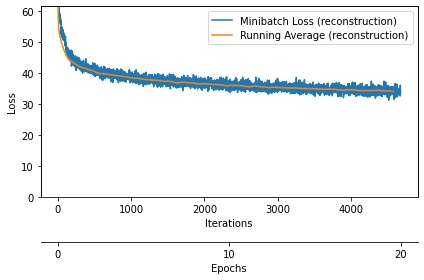

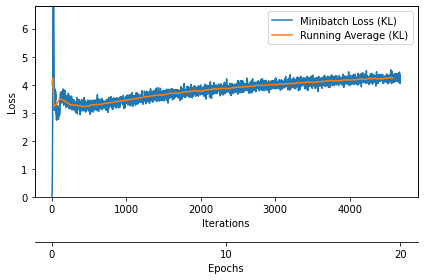

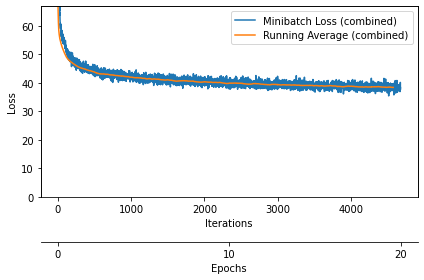

In [ ]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

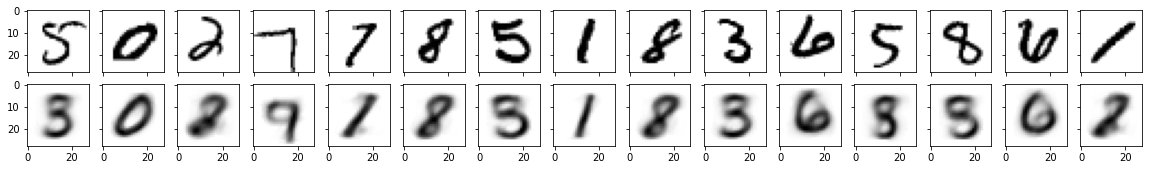

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')

## Even though images are blurry with just 20 epochs of training the neural network could generate it well.

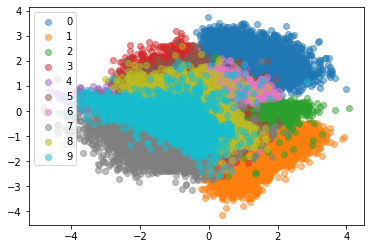

In [ ]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn,
    device=DEVICE)

plt.legend()
plt.show()

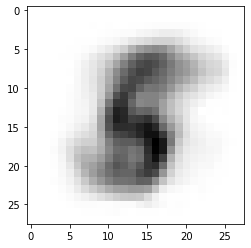

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

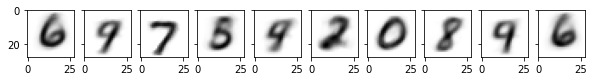

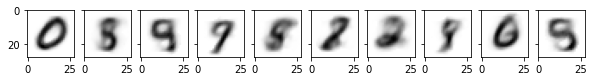

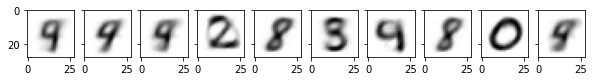

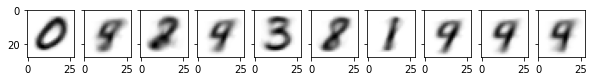

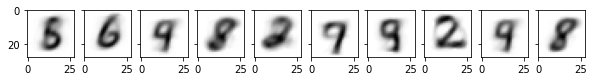

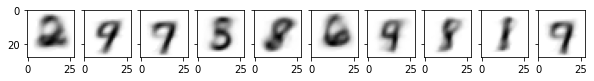

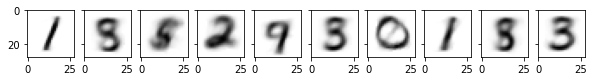

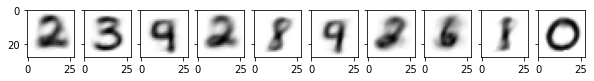

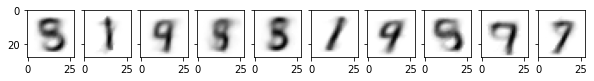

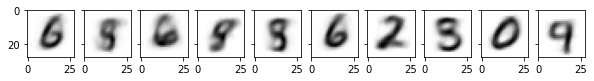

In [ ]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()

In [ ]:
import numpy as np

In [ ]:
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

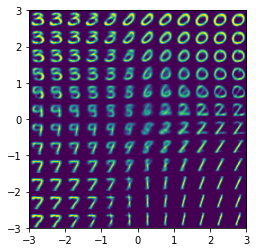

In [ ]:
plot_reconstructed(model)

## We can see that eventhough the images are blurry there is no overlap issue like the previous model.

## The images aren't overlapping and the images are one of the available 10 images.